In [36]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import csv
import time
driver = webdriver.Chrome()
print("""please note:
      1.This analysis is effecient only for top players.
      2.The analysis is only for a particular month of a particlar year.
      """)
player_name=input("Enter player username")
host=input("Enter host name of computer")
year=input("Enter year of which analysis is needed(YYYY)")
month=input("Enter month of which analysis is needed(MM)")

url=f"https://api.chess.com/pub/player/{player_name}/games/{year}/{month}/pgn"

driver.get(url)
time.sleep(8)

fpath=rf"C:\Users\{host}\Downloads\ChessCom_{player_name.lower()}_{year}{month}.pgn" 

print(fpath)

please note:
      1.This analysis is effecient only for top players.
      2.The analysis is only for a particular month of a particlar year.
      
C:\Users\raksh\Downloads\ChessCom_hikaru_202401.pgn


In [37]:
import pandas as pd
import re

def parse_pgn(pgn):
    """ Parse a single game's PGN data and return a dictionary with key details including moves. """
    pgn_data = {
        "Event": "",
        "Site": "",
        "Date": "",
        "Round": "",
        "White": "",
        "Black": "",
        "Result": "",
        "WhiteElo": "",
        "BlackElo": "",
        "TimeControl": "",
        "EndTime": "",
        "Termination": "",
        "Moves": ""
    }

    # Regular expression patterns for PGN data extraction
    patterns = {
        "Event": r"\[Event \"(.*?)\"\]",
        "Site": r"\[Site \"(.*?)\"\]",
        "Date": r"\[Date \"(.*?)\"\]",
        "Round": r"\[Round \"(.*?)\"\]",
        "White": r"\[White \"(.*?)\"\]",
        "Black": r"\[Black \"(.*?)\"\]",
        "Result": r"\[Result \"(.*?)\"\]",
        "WhiteElo": r"\[WhiteElo \"(.*?)\"\]",
        "BlackElo": r"\[BlackElo \"(.*?)\"\]",
        "TimeControl": r"\[TimeControl \"(.*?)\"\]",
        "EndTime": r"\[EndTime \"(.*?)\"\]",
        "Termination": r"\[Termination \"(.*?)\"\]"
    }

    # Extract data using regular expressions
    for key, pattern in patterns.items():
        match = re.search(pattern, pgn, re.MULTILINE)
        if match and match.group(1):
            pgn_data[key] = match.group(1)

    # Extract and clean moves
    moves_string = re.sub(r"\[.*?\]", "", pgn)  # Remove header
    moves_string = re.sub(r"1-0|0-1|1/2-1/2", "", moves_string)  # Remove game result
    moves_string = re.sub(r"\{.*?\}", "", moves_string)  # Remove inline annotations
    moves_string = re.sub(r"\n", " ", moves_string)  # Replace newline characters with space
    moves_string = re.sub(r"\s{2,}", " ", moves_string)  # Replace multiple spaces with a single space
    moves_string = moves_string.strip()  # Remove leading and trailing whitespace
    pgn_data["Moves"] = moves_string

    return pgn_data

def parse_pgn_files(file_paths):
    """ Parse multiple PGN files and return a DataFrame with all games' data. """
    all_games = []
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            pgn_text = file.read()
            games = re.split(r"\n\n\[[Ee]vent ", pgn_text)  # Split at '[Event ' to separate individual games
            for game in games:
                if game.strip():
                    game = "[Event " + game  # Add back '[Event ' to the start of each game
                    game_data = parse_pgn(game)
                    all_games.append(game_data)

    return pd.DataFrame(all_games)

# Example usage with a list of file paths
file_paths = [fpath  for i in range(0, 57)]
#print(file_paths)
all_games_df = parse_pgn_files(file_paths)

# Display the total number of games
total_games = len(all_games_df)
print(f"Total games: {total_games}")

# Print the first 5 games
print(all_games_df.head())


Total games: 59565
        Event       Site        Date Round      White      Black Result  \
0  Live Chess  Chess.com  2024.01.31     -  Snowflake     Hikaru    0-1   
1  Live Chess  Chess.com  2024.01.31     -     Hikaru  Snowflake    1-0   
2  Live Chess  Chess.com  2024.01.31     -  Snowflake     Hikaru    0-1   
3  Live Chess  Chess.com  2024.01.31     -     Hikaru  Snowflake    1-0   
4  Live Chess  Chess.com  2024.01.31     -  Snowflake     Hikaru    0-1   

  WhiteElo BlackElo TimeControl   EndTime                Termination  \
0     2924     3323         180  21:22:27  Hikaru won by resignation   
1     3321     2926         180  21:17:10  Hikaru won by resignation   
2     2928     3319         180  21:14:59  Hikaru won by resignation   
3     3317     2930         180  21:09:03  Hikaru won by resignation   
4     2932     3315         180  21:05:12  Hikaru won by resignation   

                                               Moves  
0  1. e4 1... g6 2. d4 2... Bg7 3. Nc3 3..

## What Is My Overall Win Rate?

In [38]:
# Filter the games where I am the white or black player
your_games = all_games_df[(all_games_df['White'] == player_name) | (all_games_df['Black'] == player_name)]

# Count the number of games I won as White
white_wins = your_games[(your_games['White'] == player_name) & (your_games['Result'] == '1-0')]['Result'].count()

# Count the number of games I won as Black
black_wins = your_games[(your_games['Black'] == player_name) & (your_games['Result'] == '0-1')]['Result'].count()

# Calculate the total number of games I played
total_games = len(your_games)

# Calculate my winrate
winrate = round(((white_wins + black_wins) / total_games) * 100, 2)

# Display the number of wins and win rate
print("Number of wins: ", white_wins + black_wins)
print("Overall win rate: ", round(winrate, 2), "%")


Number of wins:  48906
Overall win rate:  82.11 %


## How Many Games Have I Played In Modes Rapid, Blitz and Bullet?

In [39]:
# Create a function to categorize games based on time control
def categorize_time_control(time_control):
    if time_control in ["600+10", "600", "900+10"]:
        return "Rapid"
    elif time_control in ["300+5", "300+2", "300", "180+2", "180"]:
        return "Blitz"
    elif time_control in ["120+1", "60+1", "60"]:
        return "Bullet"
    else:
        return "Other"

# Filter the games where I am the white or black player
your_games = all_games_df[(all_games_df['White'] == player_name) | (all_games_df['Black'] == player_name)]

# Add a new column 'TimeControlCategory' to categorize games
your_games['TimeControlCategory'] = your_games['TimeControl'].apply(categorize_time_control)

# Calculate the number of games played in each category
game_counts = your_games['TimeControlCategory'].value_counts()

game_counts


TimeControlCategory
Blitz     36879
Bullet    15903
Other      6783
Name: count, dtype: int64

## What Is My Win Rate In Each Time Control?

In [40]:
# Create a function to calculate win rate for a given category
def calculate_win_rate(category):
    category_games = your_games[your_games['TimeControlCategory'] == category]
    total_games = len(category_games)
    wins = 0

    for index, row in category_games.iterrows():
        if row['White'] == player_name and row['Result'] == '1-0':
            wins += 1
        elif row['Black'] == player_name and row['Result'] == '0-1':
            wins += 1

    if total_games == 0:
        return 0
    else:
        return round((wins / total_games) * 100, 2)

# Calculate win rate for each category
win_rate_blitz = calculate_win_rate("Blitz")
win_rate_bullet = calculate_win_rate("Bullet")
win_rate_rapid = calculate_win_rate("Rapid")

print("Win rate in Blitz:", round(win_rate_blitz, 2), "%")
print("Win rate in Bullet:", round(win_rate_bullet, 2), "%")
print("Win rate in Rapid:", round(win_rate_rapid, 2), "%")


Win rate in Blitz: 83.62 %
Win rate in Bullet: 82.08 %
Win rate in Rapid: 0 %


## Visualization of My Results

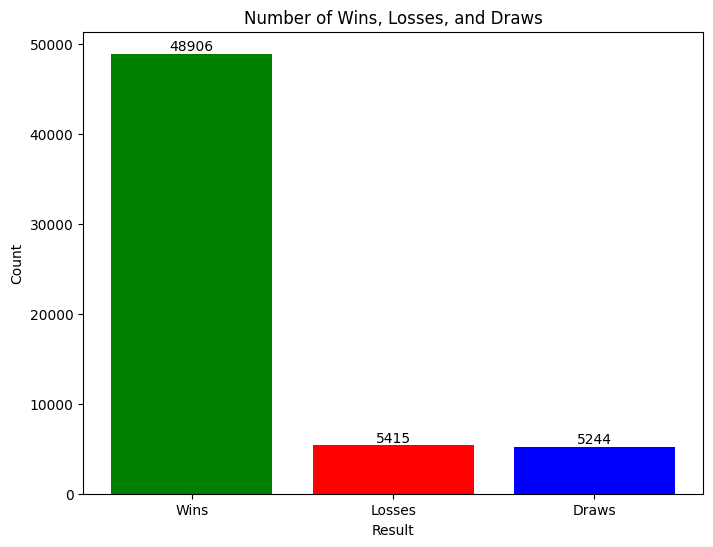

In [41]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Filter games where I am White or Black
your_games = all_games_df[(all_games_df['White'] == player_name) | (all_games_df['Black'] == player_name)]

# Separate wins, losses, and draws for White and Black
white_wins = your_games[(your_games['White'] == player_name) & (your_games['Result'] == '1-0')]['Result'].count()
black_wins = your_games[(your_games['Black'] == player_name) & (your_games['Result'] == '0-1')]['Result'].count()
white_losses = your_games[(your_games['White'] == player_name) & (your_games['Result'] == '0-1')]['Result'].count()
black_losses = your_games[(your_games['Black'] == player_name) & (your_games['Result'] == '1-0')]['Result'].count()
white_draws = your_games[(your_games['White'] == player_name) & (your_games['Result'] == '1/2-1/2')]['Result'].count()
black_draws = your_games[(your_games['Black'] == player_name) & (your_games['Result'] == '1/2-1/2')]['Result'].count()

# Calculate total wins, losses, and draws
total_wins = white_wins + black_wins
total_losses = white_losses + black_losses
total_draws = white_draws + black_draws

# Create a bar chart
results = ['Wins', 'Losses', 'Draws']
counts = [total_wins, total_losses, total_draws]

plt.figure(figsize=(8, 6))
plt.bar(results, counts, color=['green', 'red', 'blue'])
plt.title("Number of Wins, Losses, and Draws")
plt.xlabel("Result")
plt.ylabel("Count")

# Add labels to the bars
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()


## How Did My Wins Occur?

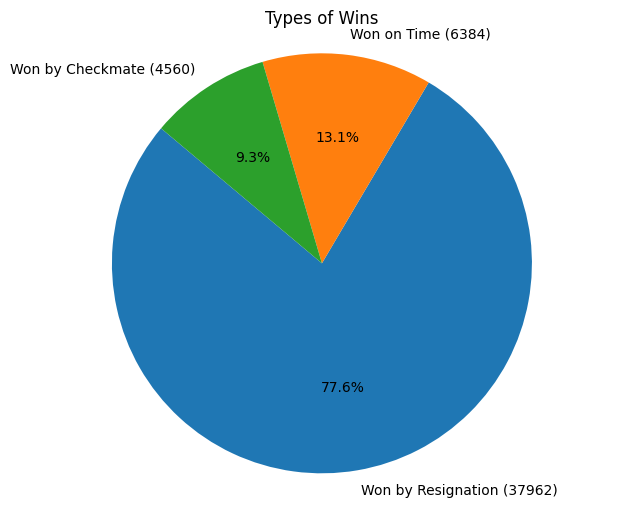

In [42]:
import matplotlib.pyplot as plt

# Filter my won games as White and create a copy of the DataFrame
white_wins = your_games[(your_games['White'] == player_name) & (your_games['Result'] == '1-0')].copy()

# Filter my won games as Black and create a copy of the DataFrame
black_wins = your_games[(your_games['Black'] == player_name) & (your_games['Result'] == '0-1')].copy()

# Concatenate the two DataFrames to get all my wins
your_won_games = pd.concat([white_wins, black_wins])

# Create a function to categorize the types of wins
def categorize_win_type(termination):
    if 'won on time' in termination:
        return 'Won on Time'
    elif 'checkmate' in termination:
        return 'Won by Checkmate'
    elif 'abandoned' in termination:
        return 'Won by Game Abandoned'
    elif 'resignation' in termination:
        return 'Won by Resignation'
    else:
        return 'Other'

# Add a new column 'WinType' to categorize the types of wins
your_won_games['WinType'] = your_won_games['Termination'].apply(categorize_win_type)

# Calculate the number and percentage of each type of win
win_type_counts = your_won_games['WinType'].value_counts()
total_won_games = len(your_won_games)
win_type_percentages = (win_type_counts / total_won_games) * 100

# Create a pie chart to visualize the types of wins
plt.figure(figsize=(8, 6))
plt.pie(win_type_counts, labels=[f"{win_type} ({count})" for win_type, count in zip(win_type_counts.index, win_type_counts)], autopct='%1.1f%%', startangle=140)
plt.title("Types of Wins")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


## How Did My Draws Occur?

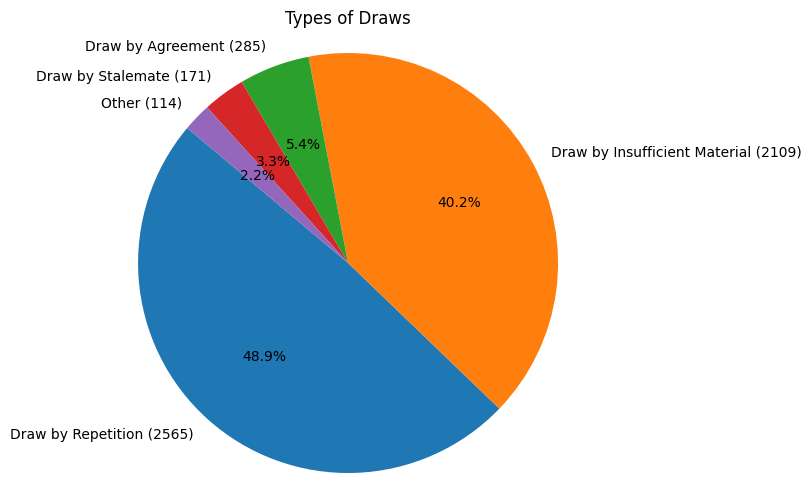

In [43]:
import matplotlib.pyplot as plt

# Filter my drawn games as White and create a copy of the DataFrame
white_draws = your_games[(your_games['White'] == player_name) & (your_games['Result'] == '1/2-1/2')].copy()

# Filter my drawn games as Black and create a copy of the DataFrame
black_draws = your_games[(your_games['Black'] == player_name) & (your_games['Result'] == '1/2-1/2')].copy()

# Concatenate the two DataFrames to get all my drawn games
your_drawn_games = pd.concat([white_draws, black_draws])

# Create a function to categorize the types of draws
def categorize_draw_type(termination):
    if 'insufficient material' in termination:
        return 'Draw by Insufficient Material'
    elif 'repetition' in termination:
        return 'Draw by Repetition'
    elif 'agreement' in termination:
        return 'Draw by Agreement'
    elif 'stalemate' in termination:
        return 'Draw by Stalemate'
    else:
        return 'Other'

# Add a new column 'DrawType' to categorize the types of draws
your_drawn_games['DrawType'] = your_drawn_games['Termination'].apply(categorize_draw_type)

# Calculate the number of each type of draw
draw_type_counts = your_drawn_games['DrawType'].value_counts()

# Create a pie chart to visualize the types of draws
plt.figure(figsize=(8, 6))
plt.pie(draw_type_counts, labels=[f"{draw_type} ({count})" for draw_type, count in zip(draw_type_counts.index, draw_type_counts)], autopct='%1.1f%%', startangle=140)
plt.title("Types of Draws")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


## How Did My Losses Occur?

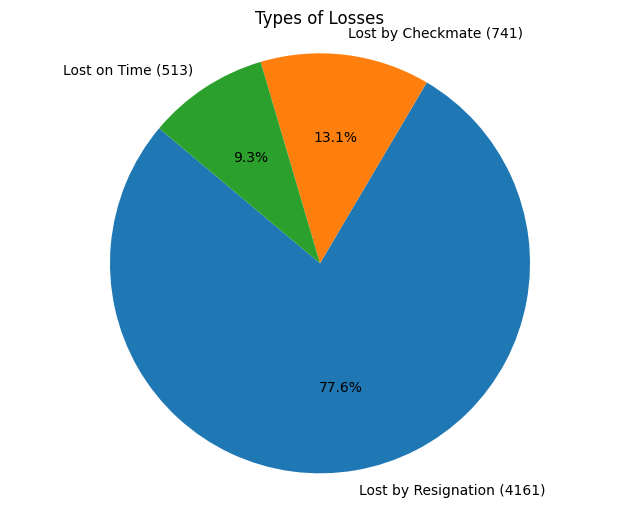

In [44]:
import matplotlib.pyplot as plt

# Filter my lost games as White and create a copy of the DataFrame
white_losses = your_games[(your_games['White'] == player_name) & (your_games['Result'] == '0-1')].copy()

# Filter my lost games as Black and create a copy of the DataFrame
black_losses = your_games[(your_games['Black'] == player_name) & (your_games['Result'] == '1-0')].copy()

# Concatenate the two DataFrames to get all my losses
your_lost_games = pd.concat([white_losses, black_losses])

# Create a function to categorize the types of losses
def categorize_win_type(termination):
    if 'won on time' in termination:
        return 'Lost on Time'
    elif 'checkmate' in termination:
        return 'Lost by Checkmate'
    elif 'abandoned' in termination:
        return 'Lost by Game Abandoned'
    elif 'resignation' in termination:
        return 'Lost by Resignation'
    else:
        return 'Other'

# Add a new column 'LossType' to categorize the types of losses
your_lost_games['LossType'] = your_lost_games['Termination'].apply(categorize_win_type)

# Calculate the number and percentage of each type of loss
loss_type_counts = your_lost_games['LossType'].value_counts()
total_lost_games = len(your_lost_games)
loss_type_percentages = (loss_type_counts / total_lost_games) * 100

# Create a pie chart to visualize the types of losses
plt.figure(figsize=(8, 6))
plt.pie(win_type_counts, labels=[f"{win_type} ({count})" for win_type, count in zip(loss_type_counts.index, loss_type_counts)], autopct='%1.1f%%', startangle=140)
plt.title("Types of Losses")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


## How Many Games Did I Play As White or Black?

In [45]:
import pandas as pd

# Count the number of games where I played as White and Black
white_games = all_games_df[all_games_df['White'] == player_name]
black_games = all_games_df[all_games_df['Black'] == player_name]

# Calculate the total number of games I played
total_games = len(all_games_df)

# Calculate the number of games played as White and Black
white_count = len(white_games)
black_count = len(black_games)

# Calculate the percentages
white_percentage = (white_count / total_games) * 100
black_percentage = (black_count / total_games) * 100

# Print the results
print(f"Total games played: {total_games}")
print(f"Games played as White: {white_count} ({white_percentage:.2f}%)")
print(f"Games played as Black: {black_count} ({black_percentage:.2f}%)")


Total games played: 59565
Games played as White: 29982 (50.33%)
Games played as Black: 29583 (49.67%)


## Which Day of the Week Is My Most Successful?

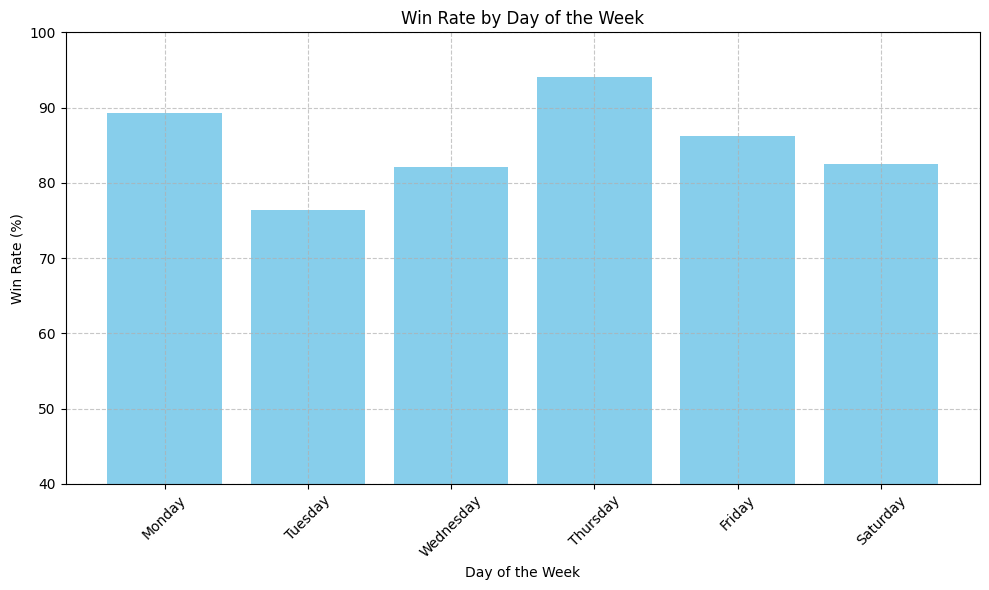

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'Date' column to datetime
your_games['Date'] = pd.to_datetime(your_games['Date'])

# Extract the day of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
your_games['DayOfWeek'] = your_games['Date'].dt.dayofweek

# Count the number of games played on each day of the week
games_by_day_of_week = your_games['DayOfWeek'].value_counts().sort_index()

# Create a dictionary to map day of the week to its name
days_of_week = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Filter my games where I won as White
white_wins = your_games[(your_games['White'] == player_name) & (your_games['Result'] == '1-0')]

# Filter my games where I won as Black
black_wins = your_games[(your_games['Black'] ==player_name) & (your_games['Result'] == '0-1')]

# Concatenate the two DataFrames to get all my wins
your_wins = pd.concat([white_wins, black_wins])

# Count the number of wins in each day of the week
wins_by_day_of_week = your_wins['DayOfWeek'].value_counts().sort_index()

# Calculate the win rate for each day of the week
win_rate_by_day_of_week = (wins_by_day_of_week / games_by_day_of_week * 100).fillna(0)

# Create a bar chart to visualize the win rate on each day of the week
plt.figure(figsize=(10, 6))
plt.bar(win_rate_by_day_of_week.index.map(days_of_week.get), win_rate_by_day_of_week.values, color='skyblue')
plt.title('Win Rate by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Win Rate (%)')
plt.ylim(40, 100)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid
plt.show()


## What Is the Average Number Of Moves In a Game? 

In [52]:
# Function to count the number of moves (plies) in a game's move sequence
def count_moves(move_sequence):
    # Splitting the move sequence into individual moves and filtering out empty strings
    moves = [move for move in move_sequence.split(' ') if move]
    return len(moves) // 2  # Dividing by 2 to get the count of full moves

# Apply the function to each game and add a new column for move counts
all_games_df['MoveCount'] = all_games_df['Moves'].apply(count_moves)

# Calculate the average number of moves per game
average_moves = all_games_df['MoveCount'].mean()
print(f"Average number of moves per game: {average_moves:.2f}")


Average number of moves per game: 89.36


## What Are My First Moves as White?

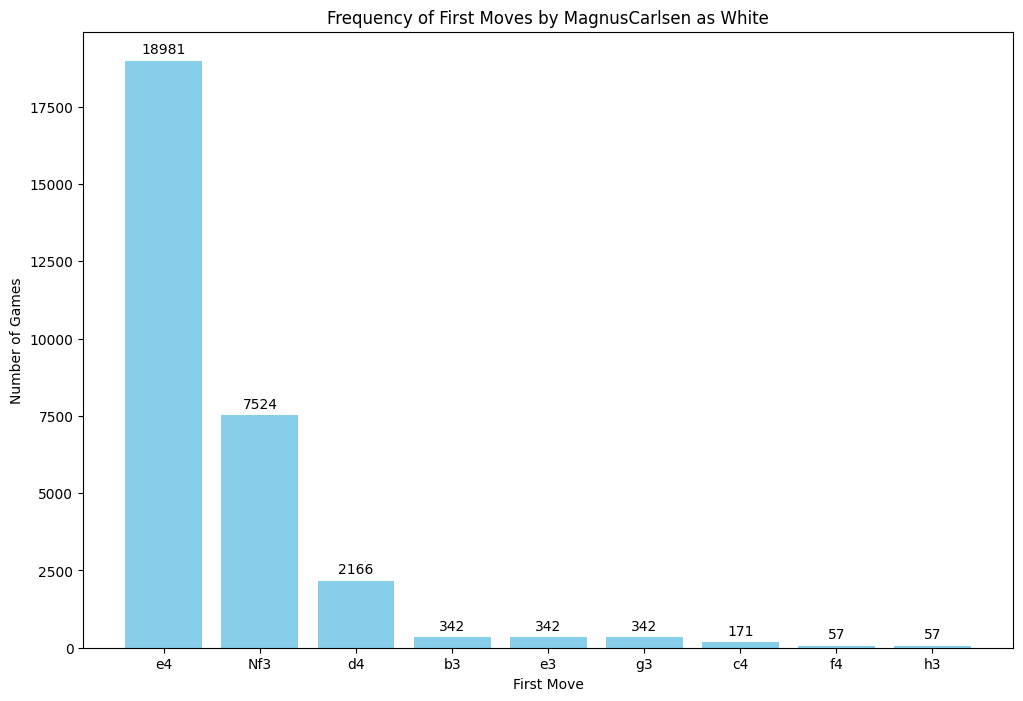

In [53]:
import matplotlib.pyplot as plt

# Filter for games where I am the white player and create a copy to avoid the warning
player_white_games = all_games_df[all_games_df['White'] == player_name].copy()

# Function to extract the first move
def extract_first_move(moves):
    # Split the moves string by space and extract the first move after "1."
    moves_list = moves.split()
    # Find the index of "1." and get the next element in the list, which is the first move
    try:
        move_index = moves_list.index('1.') + 1
    except ValueError:
        return None  # In case "1." is not found, return None
    return moves_list[move_index] if len(moves_list) > move_index else None

# Apply the function to extract the first move for each game
player_white_games['FirstMove'] = player_white_games['Moves'].apply(extract_first_move)

# Calculate the frequency of each first move
first_move_counts = player_white_games['FirstMove'].value_counts()

# Check if we have extracted moves properly
if not first_move_counts.empty:
    # Create a bar chart to visualize the frequency of first moves
    plt.figure(figsize=(12, 8))
    bars = plt.bar(first_move_counts.index, first_move_counts.values, color='skyblue')
    plt.xlabel('First Move')
    plt.ylabel('Number of Games')
    plt.title(f'Frequency of First Moves by {player_name} as White')
    plt.xticks(rotation=0)  # Rotate the x labels to show each move clearly
    
    # Add text annotations on top of each bar with the exact number
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')
    
    plt.show()
else:
    print(f"No valid first moves found for {player_name} as the white player.")


In [49]:
##What Are The First Moves Against Me When I Am Playing As Black?

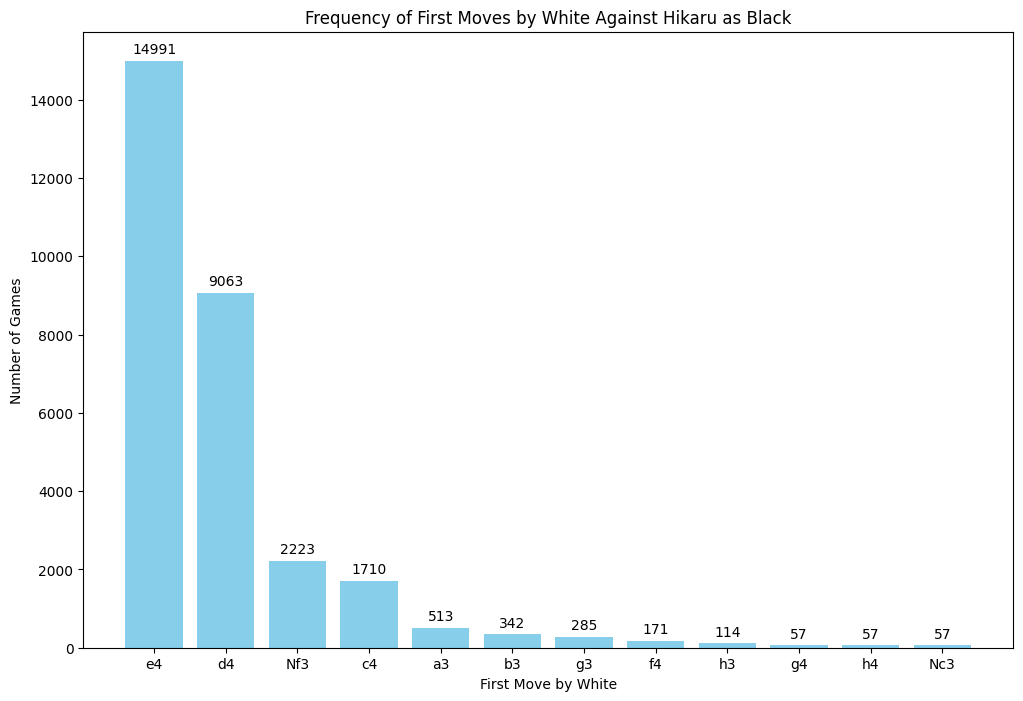

In [55]:
# Filter for games where I am the black player and create a copy to avoid the warning
player_black_games = all_games_df[all_games_df['Black'] == player_name].copy()

# Apply the function to extract the first move for each game by white when I am playing black
player_black_games['FirstMoveByWhite'] = player_black_games['Moves'].apply(extract_first_move)

# Calculate the frequency of each first move by white
first_move_counts_black = player_black_games['FirstMoveByWhite'].value_counts()

# Check if we have extracted moves properly
if not first_move_counts_black.empty:
    # Create a bar chart to visualize the frequency of first moves by white
    plt.figure(figsize=(12, 8))
    bars = plt.bar(first_move_counts_black.index, first_move_counts_black.values, color='skyblue')
    plt.xlabel('First Move by White')
    plt.ylabel('Number of Games')
    plt.title(f'Frequency of First Moves by White Against {player_name} as Black')
    plt.xticks(rotation=0)  # Rotate the x labels to show each move clearly
    
    # Add text annotations on top of each bar with the exact number
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')
    
    plt.show()
else:
    print(f"No valid first moves by white found when {player_name} is playing as black.")